## Brand Value and Customer's Reflection 

Goal: By comparing user comments to keywords, we will evaluate the alignment of the brand's mission statements (how they intend to potray themselves) to user's perception of their brands. We aim to quantify how much consumers reflect the brand's values. 

The alignment is calculated using Sentence Transformer alignment score and cosine similarity



In [ ]:

import gc
gc.collect()
import pandas as pd
import numpy as np
# import spacy
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob 
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import cos_sim

import torch
import webbrowser
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import gensim
from gensim.models import LdaModel  
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel 

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from keybert import KeyBERT
kw_model = KeyBERT(model='all-MiniLM-L6-v2')  


/opt/miniconda3/envs/qss-nlp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/floodywaves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
data_path = '../../../data'


In [8]:
#Loading the data
brand_value = pd.read_csv(data_path + "/brand_values.csv")
user_comment = pd.read_csv(data_path + "/reddit/subreddit_comment_data.csv")

brand_value.columns = brand_value.columns.str.strip().str.lower()
user_comment.columns = user_comment.columns.str.strip().str.lower()

user_comment = user_comment[user_comment["brand"].notna()]

user_comment["brand"].unique()

brand_mapping = {
    'fenty': 'Fenty Beauty',
    'Fenty': 'Fenty Beauty',
    'etude': 'Etude House',
    'e.l.f.': 'e.l.f. Cosmetics',
    'Etude': 'Etude House',
    'elf': 'e.l.f. Cosmetics', 
    'Tarte': 'Tarte Cosmetics'
}
user_comment = user_comment.dropna(subset=["brand"])
user_comment["brand"] = user_comment["brand"].replace(brand_mapping) 

def normalize_brand(name):
    return brand_mapping.get(name.lower().strip(), name.strip())

user_comment["normalized_brand"] = user_comment["brand"].apply(normalize_brand)

user_comment["brand"].unique()

array(['Estée Lauder', 'Fenty Beauty', 'e.l.f. Cosmetics',
       'Tarte Cosmetics', 'Glossier', 'Laneige', 'Sulwhasoo',
       'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [9]:


tqdm.pandas()
user_comment.columns = user_comment.columns.str.strip().str.lower()

custom_stopwords = [    "follow", "like", "likes", "just", "really", "thanks", "omg",
    "hi", "hey", "pls", "please", "gonna", "tbh", "honestly",
    "lol", "lmao", "idk", "link", "click", "watch", "dm", "recommend",]
stopword_set = set(nltk_stopwords.words('english')).union(custom_stopwords)
junk_words = {"breast", "trip", "solo", "hi", "wonder", "style", "shop", "list", "diy", "details", "ready"}

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|u/\w+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    tokens = word_tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stopword_set 
                      and t not in junk_words
                      and len(t) > 2]
    return " ".join(filtered_tokens)

user_comment["cleaned_comment"] = user_comment["comment"].progress_apply(clean_text)
user_comment = user_comment[user_comment["cleaned_comment"].str.split().str.len() > 3]

# Ignore words that are too common or too rare
tfidf = TfidfVectorizer(
    max_df=0.8,
    min_df=2, 
    max_features=10000,
    stop_words=list(stopword_set)
)
X = tfidf.fit_transform(user_comment["cleaned_comment"])
important_words = set(tfidf.get_feature_names_out())

user_comment["cleaned_comment"] = user_comment["cleaned_comment"].progress_apply(
    lambda doc: " ".join([w for w in doc.split() if w in important_words])
)
user_comment.head()

100%|██████████| 4056/4056 [00:00<00:00, 249751.85it/s]


,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...,try use chest area see tolerated otherwise wou...,Estée Lauder
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...,used serum years one favourites use couple dro...,Estée Lauder
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and...",use faster use sooner replace course company w...,Estée Lauder
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...,serums need drops cover face see half dropper ...,Estée Lauder
5,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Hi am I the only one who feel like my serum bo...,one feel serum bottle close properly tried tur...,Estée Lauder


In [10]:
brand_value = brand_value.rename(columns={"brand": "search_term", "values/ mission": "brand_mission"})

new_df = user_comment.merge(
    brand_value[["search_term", "brand_mission"]],
    left_on="brand",
    right_on="search_term",
    how="inner"
)

new_df.head()

,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...,try use chest area see tolerated otherwise wou...,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...
1,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...,used serum years one favourites use couple dro...,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and...",use faster use sooner replace course company w...,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...,serums need drops cover face see half dropper ...,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Hi am I the only one who feel like my serum bo...,one feel serum bottle close properly tried tur...,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...


In [124]:
print(new_df.columns) 

Index(['post_id', 'title', 'brand', 'subreddit_name', 'comment',
       'cleaned_comment', 'normalized_brand', 'search_term', 'brand_mission'],
      dtype='object')


In [11]:
# Compute alignment score
tqdm.pandas()
model = SentenceTransformer('all-MiniLM-L6-v2')

sample_df = new_df.sample(2000, random_state=42)

# Encode the instagram comments as a vector 
# Meaning instrament comment matrix
text_embeds = model.encode(
    sample_df["cleaned_comment"].tolist(), 
    convert_to_tensor=True, 
    batch_size=64,     
    show_progress_bar=True
) 

brand_names = brand_value["search_term"].tolist()
brand_missions = brand_value["brand_mission"].tolist()

# Encode all brand mission statements at once
# Should out 10 vectors for each brand mission statement
brand_mission_embeds = model.encode(
    brand_missions,
    convert_to_tensor=True,
    batch_size=10,  
    show_progress_bar=False
)
# Create a dictionary to map brand names to their indices offor quick lookup on brand_mission_embeds
brand_index = {brand: i for i, brand in enumerate(brand_names)}
# Map to the numeric index
brand_indices_tensor = torch.tensor(
    sample_df["brand"].map(brand_index).tolist(), 
    device=text_embeds.device 
)

selected_brand_embeds = brand_mission_embeds[brand_indices_tensor] # grab the correct brand mission statement

# Vectorized cosine similarity between matching brand mission and instagram comments
similarities = cos_sim(text_embeds, selected_brand_embeds).diagonal()

sample_df["alignment_score"] = similarities.cpu().numpy().tolist()


Batches: 100%|██████████| 32/32 [00:03<00:00, 10.62it/s]


In [19]:
pd.set_option("display.max_colwidth", None)
sample_df[sample_df["brand"] == "COSRX"].sort_values("alignment_score", ascending=False)


,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission,alignment_score,z_score
3345,17lp49z,Has anyone tried the newest COSRX The 6 Peptide Skin Booster Serum?,COSRX,AsianBeauty,"As much as I love cosrx this is a whole scam . The peptides are not going to do anything for if you're above 30 and have mature skin. These are basic peptides to start of you're at your 20s.....this feels nice on the skin I'm a oily skin person and it felt really good on the skin but just like any other hydrating toners or moisturizer....why buy this instead of a moisturizer ? There's only one copper peptide which is the copper tripeptide . Very weak ingredients....with the price of it you can buy a copper peptide serum , a multipeptide or argline serum and a retinol.....which will work way better for your skin than this in the long term. The amount of peptides are stupidly low for the price .",much love cosrx whole scam peptides going anything mature skin basic peptides start feels nice skin oily skin person felt good skin hydrating toners moisturizer buy instead moisturizer one copper peptide copper weak ingredients price buy copper peptide serum serum retinol work way better skin long term amount peptides low price,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.676382,2.525551
3321,mlp339,COSRX Snail Mucin Essence: 3 week results,COSRX,AsianBeauty,"Amazing results - your skin is looking great!\n\nI LOVE this product. I'm a huge Cosrx fan having started out with this. I use it with their Low PH Good Morning Cleanser, AHA/BHA Clarifying Treatment Toner and oil free ultra-moisturising lotion along with TO Niacinamide + zinc, buffet and 5% caffeine in both the AM and PM. I add TO granactive retanoid emulsion 2% in the PM and Pyunkang Yul black tea time reverse eye cream in the PM and I have the most clear, bright skin in years.\n\nAging + oily/combination skin makes for one hell of a routine!",amazing results skin looking great love product huge cosrx fan started use low good morning cleanser aha bha clarifying treatment toner oil free ultra moisturising lotion along niacinamide zinc buffet caffeine add granactive emulsion pyunkang yul black tea time reverse eye cream clear bright skin years aging oily combination skin makes one hell routine,COSRX,COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.617941,2.141600
3604,ng439y,[REVIEW] COSRX Hydrium Triple Hyaluronic Moisture Ampoule,COSRX,KoreanBeauty,"I really, really like the COSRX, but ANY product that has nothing else than just hyaluronic acid, that does nothing else than to hydrate, seems a bit waste of money to me. Especially with Korean skincare, you have hyaluronic acid nearly everytime included in the product, plus you can also choose a product that has other hydrating ingredients. As well as healing, soothing or strengthening the skin barrier. \nI like Korean skincare because it usually offers a multiple targeting of skin issues. This hyaluronic acid serum reminds me a western skincare. \nI would rather pick something like iUNIK Beta glucan serum. Which ha

In [13]:
#Summary Data 
sample_df["z_score"] = sample_df.groupby("brand")["alignment_score"].transform(zscore)

insight = sample_df.groupby("brand").agg(
    mean_alignment = ("alignment_score", "mean"), 
    mean_z_alignment = ("z_score", "mean")).reset_index()

insight 

,brand,mean_alignment,mean_z_alignment
0,COSRX,0.291968,8.881784e-17
1,Estée Lauder,0.062050,-2.473269e-17
2,Etude House,0.069394,-5.441841e-17
3,Fenty Beauty,0.262853,-1.433774e-16
4,Glossier,0.300709,-6.453735e-17
5,Innisfree,0.140978,8.199174e-17
6,Laneige,0.310229,-1.941496e-16
7,Sulwhasoo,0.331018,-4.977577e-17
8,Tarte Cosmetics,0.169363,-6.613633e-17
9,e.l.f. Cosmetics,0.180947,-3.932040e-17


In [14]:
#Classify the alignment score into top alignments and create a new dataframe

top_alignment_comment = sample_df.sort_values("alignment_score", ascending=False).drop_duplicates("brand")
top_alignment_comment["alignment_type"] = "Top Aligned"

low_alignment_comment = sample_df.sort_values("alignment_score", ascending=True).drop_duplicates("brand")
low_alignment_comment["alignment_type"] = "Lowest Aligned"

both_df = pd.concat([top_alignment_comment, low_alignment_comment]).sort_values(["brand", "alignment_type"])

both_df


,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission,alignment_score,z_score,alignment_type
927,rnt36g,[review] COSRX snail mucin essence,COSRX,SkincareAddiction,"I tried to like it, but it broke me out every ...",tried broke every time tried,COSRX,COSRX,COSRX believes that cosmetics should give more...,-0.056222,-2.287556,Lowest Aligned
3345,17lp49z,Has anyone tried the newest COSRX The 6 Peptid...,COSRX,AsianBeauty,As much as I love cosrx this is a whole scam ....,much love cosrx whole scam peptides going anyt...,COSRX,COSRX,COSRX believes that cosmetics should give more...,0.676382,2.525551,Top Aligned
80,meb4ny,[Product Question] ordinary now owned by Estée...,Estée Lauder,SkincareAddiction,I’m assuming this is why the 2% SA solution ha...,assuming solution reformulating year haha,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...,-0.126131,-2.407008,Lowest Aligned
41,1i5q8th,[Product question] Dupe for Estée Lauder Advan...,Estée Lauder,SkincareAddiction,Hey! I wanted to share one of my favorite bran...,wanted share one favorite brands estee lauder ...,Estée Lauder,Estée Lauder,A force is an influence. A force of nature. A ...,0.261369,2.549475,Top Aligned
2619,ihb7pe,[Review]: Etude House Soon Jung pH 5.5 Foam Cl...,Etude House,AsianBeauty,Thanks for the review! The whip used to be my ...,review whip used started tret drying skin thin...,Etude House,Etude House,The name ‘Etude’ means ‘beautiful study of Cho...,-0.133995,-2.034371,Lowest Aligned
2899,1get5qu,Etude’s Holiday Collections Going Back to 2010,Etude House,AsianBeauty,I‘m sure Etude would be selling so much better...,sure etude would selling much better released ...,Etude House,Etude House,The name ‘Etude’ means ‘beautiful study of Cho...,0.426672,3.573625,Top Aligned
1181,1blklab,Fenty Beauty is 25% off for anyone that has an...,Fenty Beauty,Sephora,my capital one extension found a stackable cod...,one found code,Fenty Beauty,Fenty Beauty,FENTY BEAUTY: This is where Rihanna started it...,-0.082657,-2.444552,Lowest Aligned
1133,1jby5lx,Fenty Beauty Soft'Lit Foundation vs Make Up Fo...,Fenty Beauty,Sephora,"Fenty Soft Lit! Much better on my mature, dry ...",fenty soft lit much better mature dry skin bet...,Fenty Beauty,Fenty Beauty,FENTY BEAUTY: This is where Rihanna started it...,0.589743,2.312806,Top Aligned
3715,hbda0y,Used the Glossier Skin Tint and Stretch Concea...,Glossier,BrownBeauty,"Hi there, had to remove the links to your YouT...",remove links youtube post weekend tag,Glossier,Glossier,"Before we launched Glossier in 2014, we starte...",-0.082212,-2.446300,Lowest Aligned
382,f5zbjm,[Review] Glossier Futuredew,Glossier,SkincareAddiction,Product name: Glossier Futuredew\n\nPrice: $30...,product name glossier futuredew price cad usd ...,Glossier,Glossier,"Before we launched Glossier in 2014, we starte...",0.632095,2.117062,Top Aligned


In [15]:
pd.set_option("display.max_colwidth", None)
top_alignment_comment[["comment", "brand", "brand_mission", "alignment_score"]]

,comment,brand,brand_mission,alignment_score
2509,"I’ve been using the Sulwhasoo Ultimate S products for over a month and honestly, they are the best skincare products I’ve ever used! I'm 46, Caucasian and live in the southern United States. I’m not sure if I’m using all the products in exactly the right order, but this is my routine:\n\nMorning:\n1. Gentle cleansing foam\n2. First care activating serum\n3. Ultimate S balancing water\n4. Ultimate S serum\n5. Ultimate S emulsion\n6. Ultimate S eye cream\n7. Ultimate S cream \n\nEvening:\n1. Gentle cleaning oil\n2. Then same steps above\n\nI’ve noticed my wrinkles around my eyes look diminished, my skin is bright, hydrated and finally I don’t have any dry skin! I’ve also not had any breakouts at all.",Sulwhasoo,"Sulwhasoo believes that there is an innovative artist in all of us.\nWe explore our heritage for inspiration and create new things that\nchallenges and changes perspectives.\nWe drew upon our own heritage to create new products that we see as work of art as\nthey transcend time and generations. At Sulwhasoo, we believe in a holistic approach to skincare.\nGoing beyond addressing visible issues on the skin’s surface, Sulwhasoo looks deeply into the root causes of skin aging and addressing them at the source.\nOur definition of genuine skin solutions involves the recovery of skin’s rejuvenating system.\nWe believe that activating the skin’s potential is the first step towards achieving healthy-looking skin.\nFor this, Sulwhasoo presents the skincare routine, starting with First Care Activating Serum, formulated to activate your skin’s potential.",0.680042
3345,"As much as I love cosrx this is a whole scam . The peptides are not going to do anything for if you're above 30 and have mature skin. These are basic peptides to start of you're at your 20s.....this feels nice on the skin I'm a oily skin person and it felt really good on the skin but just like any other hydrating toners or moisturizer....why buy this instead of a moisturizer ? There's only one copper peptide which is the copper tripeptide . Very weak ingredients....with the price of it you can buy a copper peptide serum , a multipeptide or argline serum and a retinol.....which will work way better for your skin than this in the long term. The amount of peptides are stupidly low for the price .",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.676382
382,"Product name: Glossier Futuredew\n\nPrice: $30 CAD/$24 USD for 30 mL\n\nWarning: long review ahead!\n\nWhen I was deciding whether to buy this, I didn’t find many reviews, so now that I’ve been using it for a while, I thought I’d post a review in case anyone else was interested. I’ve been using this product for about 6 weeks. \n\nGlossier describes this product as an “oil serum hybrid” - it contains Jojoba, Grape Seed, Evening Primrose, and Rosehip Oils, as well as Squalane and Evodia Rutaecarpa Extract (fruit extract known to visibly increase brightness). It also contains mica to help give it that glowy, reflective finish. \n\nGlossier suggests applying this as the last step in your skincare routine (after sunscreen), which initially had me a bit confused, since usually sunscreen would be the last step in my skincare routine. But what I’ve now realized is that this product is not just skincare - it’s more like a skincare/makeup combo (and in my opinion, leans more towards makeup than skincare - more on that later). \n\nThis product dispenses as a peach-coloured serum with a slight pearly sheen. When applied to my face, it’

## Visualization of Alignment Score
Comparision between Korean and US Brands 

In [16]:
# Categorize the brands base on country

insight["country"] = "US Brand"

korean_brands = ["COSRX", "Etude House", "Innisfree", "Laneige", "Sulwhasoo"]
insight.loc[
    insight["brand"].str.contains("|".join(korean_brands), case=False),
    "country"] = "Korean Brand" 

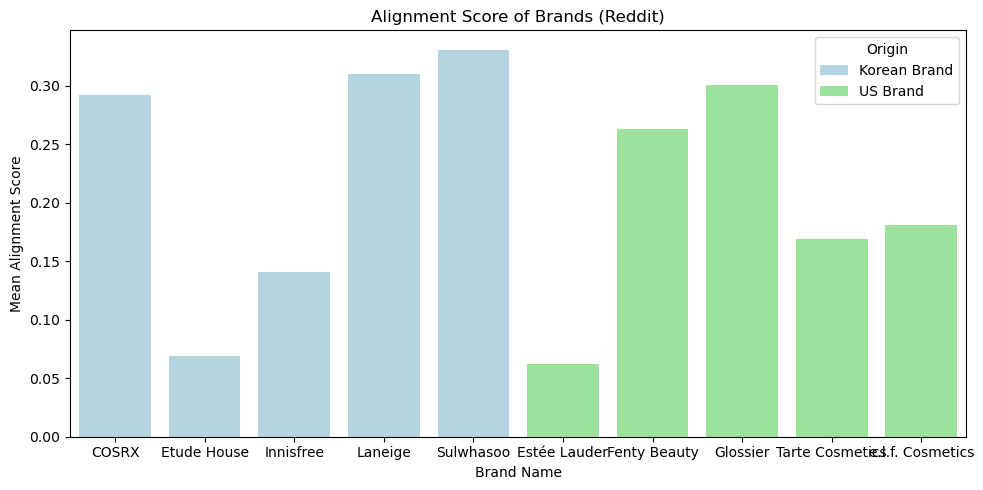

In [18]:
sorted_by_country = insight.sort_values(by=["country", "brand"])

plt.figure(figsize=(10, 5))
sns.barplot(data=sorted_by_country, x="brand", y="mean_alignment", hue="country", palette={"Korean Brand": "lightblue", "US Brand": "lightgreen"})

plt.title("Alignment Score of Brands (Reddit)")
plt.xlabel("Brand Name")
plt.ylabel("Mean Alignment Score")
plt.legend(title="Origin")
plt.tight_layout()
plt.show()

In [17]:
lemmatizer = WordNetLemmatizer()
stopword_set = set(nltk_stopwords.words('english')).union(custom_stopwords)

def preprocess(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stopword_set and len(word) > 2]

all_brands = []

brand_list = sample_df["brand"].unique().tolist()

for brand in brand_list:
    brand_df = sample_df[sample_df["brand"] == brand]
    texts = brand_df["cleaned_comment"].apply(preprocess).tolist()
    dictionary = Dictionary(texts)  
    corpus = [dictionary.doc2bow(text) for text in texts]  
    lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)  
    vis_data = gensimvis.prepare(lda, corpus, dictionary)
    pyLDAvis.save_html(vis_data, f"../output/lda/lda_{brand.lower().replace(' ', '_')}.html")
    
    # Get the top words as topic lavel 
    topic_terms = lda.show_topics(num_topics=5, num_words=10, formatted=False)
    topic_label_map = {
        topic_id: " ".join([word for word, _ in words])  
        for topic_id, words in topic_terms
    }
    
    labeled_topics = []
    for doc_bow in corpus:
        topic_probs = lda.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic_id = max(topic_probs, key=lambda x: x[1])[0]
        raw_label = topic_label_map[dominant_topic_id]
        
        phrase = ", ".join(raw_label.split())
        sentence = f"People are talking about {brand}'s products with a focus on {phrase}, which may relate to skincare concerns or product features."
        labeled_topics.append(sentence)


    brand_df["topic_label"] = labeled_topics
    brand_df["topic_label"] = labeled_topics
    all_brands.append(brand_df)


all_brands_df = pd.concat(all_brands)


/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_18886/3672158003.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_df["topic_label"] = labeled_topics
/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_18886/3672158003.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_df["topic_label"] = labeled_topics
/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_18886/3672158003.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term,brand_mission,alignment_score,z_score,topic_label
605,lstp2i,[Product Question] Laneige Cream Skin: mist or toner?,Laneige,SkincareAddiction,"I have never tried the mist, but that toner is literally my holy grail. I absolutely love that stuff and use it every day. I put on two layers while spritzing thermal water in between to get it to really soak in. It is so hydrating and plays well with all of my other products. It also lasts forever.",never tried mist toner literally holy grail absolutely love stuff use every day put two layers water get soak hydrating plays well products also lasts forever,Laneige,Laneige,"We aim to create multi-tasking products that make caring for your skin easy. Our team is fascinated by how to better hydrate skin and lips, and are dedicated to continuing to research the latest and greatest ingredients while using our innovative technology to create formulas that deliver visible results—offering the dewy, bouncy skin you love.",0.344050,0.272670,"People are talking about Laneige's products with a focus on lip, mask, laneige, one, sleeping, night, balm, use, tried, love, which may relate to skincare concerns or product features."
3855,1e8fm3w,has anyone tried laneige water bank eye cream?,Laneige,IndianSkincareAddicts,"Hey I’ll try keeping this short - \n\nIf you mention you have extreme dryness around the eyes pls avoid using eye creams esp those with a high concentration of, say, retinol. It’ll dry it out further. \nYou need to start by balancing the moisture in that region as well. Don’t ask me how, I’m no expert in this unfortunately. You’ll have to do some research or technically stop using the thing that may be drying out that region. \n\nFor dark circles, puffiness, etc (if you’re unable to stick to a sleep schedule, good diet and all) you can use any decent, well priced eye cream to reduce the _appearance_ of these. There is nothing in the market that gets rid of them, anything that claims to do so is false. \n\nYou don’t need to spend the amount given on this laneige product, you can go with any other trustworthy Indian brand like minimalist as well.",try keeping short mention extreme dryness around eyes avoid using eye creams esp high concentration say retinol dry need start balancing moisture region well ask expert unfortunately research technically stop using thing may drying region dark circles etc unable stick sleep schedule good diet use decent well priced eye cream reduce appearance nothing market gets rid anything claims need spend amount given laneige product trustworthy indian brand minimalist well,Laneige,Laneige,"We aim to create multi-tasking products that make caring for your skin easy. Our team is fascinated by how to better hydrate skin and lips, and are dedicated to continuing to research the latest and greatest ingredients while using our innovative technology to create formulas that deliver visible results—offering the dewy, bouncy skin you love.",0.262708,-0.283812,"People are talking about Laneige's products with a focus on skin, product, one, laneige, use, dry, toner, free, cream, find, which may relate to skincare concerns or product features."
3402,1d1lvu3,the laneige lip sleeping mask dried my lips so much. is this normal?,Laneige,KoreanBeauty,I have very dry lips and this happens for me. The only thing that helped me was Lanolips 12 hour lip mask\nyou can also try the lip glowy balm by laneige. I think that has better hydration.,dry lips happens thing helped lanolips hour lip mask also try lip glowy balm laneige think better hydration,Laneige,Laneige,"We aim to create multi-tasking products that make caring for your skin easy. Our team is fascinated by how to better hydrate skin and lips, and are dedicated to continuing to research the latest and greatest ingredients while using our innovative technology to create formulas that deliver visible results—offering the dewy, bouncy ski

In [31]:
all_brands_df[all_brands_df['normalized_brand'] == 'COSRX']

,post_id,title,brand,subreddit_name,comment,cleaned_comment,normalized_brand,search_term_x,alignment_score,z_score,topic_label,search_term_y,brand_mission
1682,110wklo,"hi!! ever since starting differin im really drying out. i use the COSRX all in one snail cream + the vanicream lotion for my main moisturizers but i want to add a hydrating, skin barrier repairing serum OR toner into my routine. any recs? i live in canada so pls stuff that’s available in our sephora",COSRX,Sephora,I use tret and I currently use the laneige cream skin refiner but previously used the FAB wild oat toner. I think any sort of milky toner is a nice way to hydrate your skin before using something like differin :),use tret currently use laneige cream skin refiner previously used fab wild oat toner think sort milky toner nice way hydrate skin using something differin,COSRX,COSRX,0.336324,0.379963,"People are talking about COSRX's products with a focus on skin, product, acid, serum, use, snail, day, mucin, bha, cream, which may relate to skincare concerns or product features.",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers."
1683,155ndcq,[REVIEW] COSRX advanced snail 92 all in one “cream”,COSRX,SkincareAddiction,"So here's my two cents. Mucin does appear to have healing benefits, but for skin to be healthy, it needs to retain moisture first and foremost. I found this product far too drying. The Hyaluronic acid sucked my skin dry. However, using this as a... Serum step... And then layering an occlusive moisturizer on top might be the way to go. Perhaps this product will work better underneath something more substantial",two cents mucin appear healing benefits skin healthy needs retain moisture first found product far drying hyaluronic acid sucked skin dry however using serum step layering occlusive moisturizer top might way perhaps product work better underneath something substantial,COSRX,COSRX,0.300806,0.104600,"People are talking about COSRX's products with a focus on skin, cleanser, using, product, routine, acne, gel, sunscreen, look, low, which may relate to skincare concerns or product features.",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers."
1684,1928sit,COSRX Advance Snail 96 Mucin Power Essence vs COSRX Advance Snail 96 All in one cream,COSRX,IndianSkincareAddicts,"Combination skin here- used essence in summers, switched to cream in winters. Cream is perfect in terms of texture in this weather- not too heavy not too light",combination skin used essence summers switched cream winters cream perfect terms texture weather heavy light,COSRX,COSRX,0.384081,0.750201,"People are talking about COSRX's products with a focus on skin, product, acid, serum, use, snail, day, mucin, bha, cream, which may relate to skincare concerns or product features.",COSRX,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics +

In [19]:
brand_value.head()

,search_term,slogan,brand_mission
0,Estée Lauder,Beauty is an attitude,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future."
1,Fenty Beauty,Beauty for all,"FENTY BEAUTY: This is where Rihanna started it all, for all. More than just makeup, it’s a mission with a vision, serving foundation that put every tone on the map. Launching color that created new ways of being and seeing with loaded pigments and freestyle formulas. FENTY SKIN: Great skin makes great makeup. Start your base with Fenty Skin—smart, high-performance skincare with a clear mission: treat, smooth and tighten the look of pores, day and night, under makeup and over time. Never complicated, always clinical. FENTY HAIR: The radically transformative power of hair? Rihanna owns that. But serving looks and switchin’ styles can take its toll. Enter Fenty Hair: a new era of repair. It’s a line that infuses repair into every step for styles that won’t stop. Your hair on Fenty? It’s stronger by the style."
2,e.l.f. Cosmetics,be extra withoutpaying extra,"e.l.f. is for every eye, lip and face. Your originality is our inspiration. From full-on maximalists to fresh-faced\nminimalists, we have a product for everyone—and every look in between. Look good and feel good—all our\nformulas are 100% vegan, no animal testing and made without the nasty bad-for-you stuff. Totally guilt-free."
3,Tarte Cosmetics,"Be green, be smart, be tarte.","About Tarte™\nAt tarte™, we believe in breaking down beauty\nboundaries, shattering stereotypes & being kind.\nWe believe in high-performance AND natural. All tarte products are formulated with a blend of naturally-derived & other ingredients designed to perform.\n• fruit & plant extracts from Mother Nature • clinically-proven ingredients\n• vegan-friendly options • consumer tested results"
4,Glossier,You Look Good,"Before we launched Glossier in 2014, we started as Into The Gloss. A beauty website and community devoted to sharing real information with real people, about really amazing products. It’s where we realized that beauty shouldn’t be built in a boardroom—it should be built by you. This ethos gave birth to our philosophy: Skin First. Makeup Second™. We prioritize skincare because we believe that healthy skin is the best foundation. We believe in thoughtful design and cultivating conversations. It’s at the core of everything we do—the starting point of all our makeup, skincare, bodycare, and fragrance products. At Glossier, beauty is about celebrating freedom of expression, individuality , and having fun. Our Skin First. Makeup Second™ approach ensures that every product supports your skin’s health, allowing your makeup to enhance rather than mask your natural beauty."


In [22]:
print(all_brands_df.columns)

Index(['post_id', 'title', 'brand', 'subreddit_name', 'comment',
       'cleaned_comment', 'normalized_brand', 'search_term', 'alignment_score',
       'z_score', 'topic_label'],
      dtype='object')


In [23]:
all_brands_df = all_brands_df.drop(columns=["brand_mission"], errors="ignore")

all_brands_df = all_brands_df.merge(
    brand_value[["search_term", "brand_mission"]],
    left_on="normalized_brand",
    right_on="search_term",
    how="left"
)
def compute_similarity(row):
    topic_embed = model.encode(row["topic_label"], convert_to_tensor=True)
    mission_embed = model.encode(row["brand_mission"], convert_to_tensor=True)
    return float(util.cos_sim(topic_embed, mission_embed).item())

summary = (
    all_brands_df.groupby(["normalized_brand", "topic_label", "brand_mission"])["alignment_score"]
    .mean()
    .reset_index()
)

summary["similarity_score"] = summary.apply(compute_similarity, axis=1)

# summary.to_csv('../output/topic_user_score.csv')

In [24]:
summary

,normalized_brand,topic_label,brand_mission,alignment_score,similarity_score
0,COSRX,"People are talking about COSRX's products with a focus on one, product, snail, love, skin, cosrx, used, mucin, cream, get, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.288867,0.692145
1,COSRX,"People are talking about COSRX's products with a focus on skin, cleanser, using, product, routine, acne, gel, sunscreen, look, low, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.251845,0.765481
2,COSRX,"People are talking about COSRX's products with a focus on skin, product, acid, serum, use, snail, day, mucin, bha, cream, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.309528,0.704693
3,Estée Lauder,"People are talking about Estée Lauder's products with a focus on product, eye, also, skin, missha, one, cream, dupe, good, serum, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.057117,0.248439
4,Estée Lauder,"People are talking about Estée Lauder's products with a focus on skin, foundation, get, use, also, coverage, used, one, product, time, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.080280,0.272154
5,Estée Lauder,"People are talking about Estée Lauder's products with a focus on use, skin, also, love, one, foundation, make, using, good, would, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.046944,0.347428
6,Etude House,"People are talking about Etude House's products with a focus on skin, mask, dry, one, sunscreen, would, love, cream, toner, feel, which may relate to skincare concerns or product feature

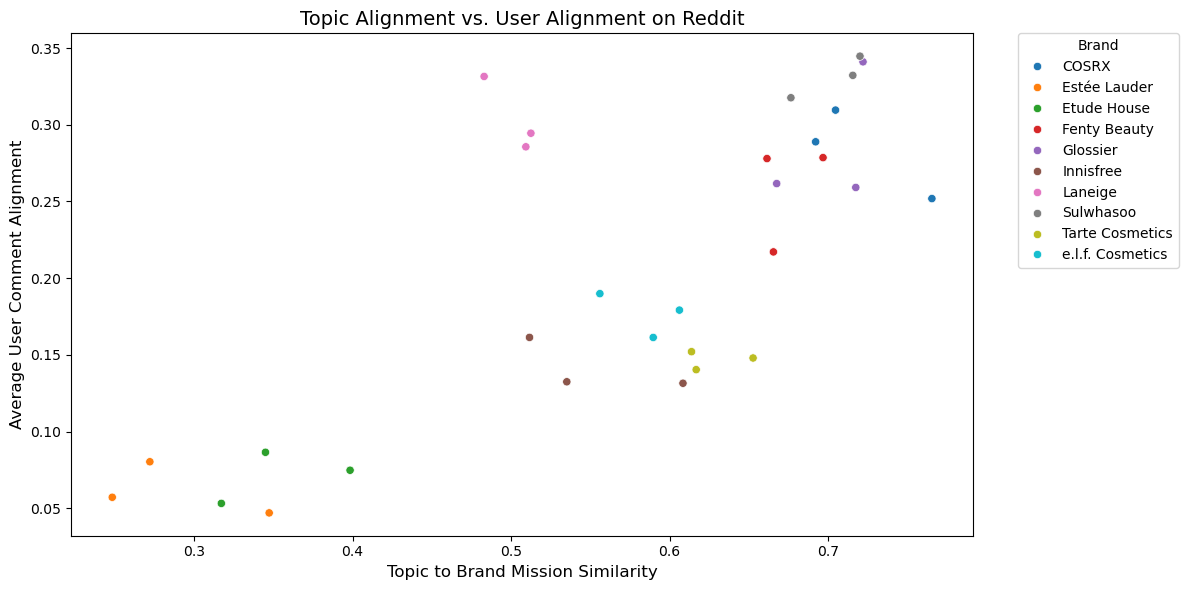

In [27]:
plt.figure(figsize=(12, 6)) 
sns.scatterplot(data=summary, x="similarity_score", y="alignment_score", hue="normalized_brand",)
plt.title("Topic Alignment vs. User Alignment on Reddit", fontsize=14)
plt.xlabel("Topic to Brand Mission Similarity", fontsize=12)
plt.ylabel("Average User Comment Alignment", fontsize=12)
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()

## Main Theme 

Analyzing the main theme of each brand's value and the main theme of the customer's comments  

In [146]:
# Extract top keywords from the brand's value and top keywords from the user's comment 

#function to clean the text 
def cleaning_the_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    return text

# function to extract keywords using FT-IDF 
def get_main_theme(text, top_n=7):
    if not text.strip():
        return None
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    get_scores = tfidf_matrix.toarray().flatten() #convert text into TF-IDF-weighted vector 
    words = vectorizer.get_feature_names_out() # get a list of main theme 
    top_indices = get_scores.argsort()[::-1][:top_n]
    top_keywords = [words[keyword] for keyword in top_indices]
    return ", ".join(top_keywords)

#building a dataframe of main themes for each 
theme_df = []

for brand, group in new_df.groupby("brand"):
    brand_mission = " ".join(group["brand_mission"].map(cleaning_the_text).unique())
    customer_comment = " ".join(group["comment"].map(cleaning_the_text))
    main_theme_brand = get_main_theme(brand_mission)
    main_theme_comment = get_main_theme(customer_comment)
    theme_df.append({
        "brand": brand,
        "brand_mission_main_theme": main_theme_brand,
        "user_comment_main_theme": main_theme_comment})

main_theme_df = pd.DataFrame(theme_df)

main_theme_df

,brand,brand_mission_main_theme,user_comment_main_theme
0,COSRX,"skin, cosmetics, beauty, customers, cosrx, want, founded","skin, like, snail, cosrx, use, using, ve"
1,Estée Lauder,"force, world, women, beauty, believed, caring, championing","skin, use, like, foundation, serum, love, ve"
2,Etude House,"make, pink, princess, like, color, women, fantasy","skin, like, use, just, ve, really, dry"
3,Fenty Beauty,"fenty, hair, makeup, skin, styles, new, repair","like, fenty, skin, love, just, really, use"
4,Glossier,"makeup, beauty, skin, built, products, real, believe","like, glossier, skin, use, cleanser, ve, just"
5,Innisfree,"nature, healthy, beauty, island, innisfree, green, benefits","skin, like, innisfree, use, ve, mask, love"
6,Laneige,"skin, create, visible, ingredients, better, bouncy, caring","lip, laneige, skin, like, mask, lips, use"
7,Sulwhasoo,"skin, sulwhasoo, create, potential, activating, addressing, heritage","skin, sulwhasoo, products, use, like, ve, just"
8,Tarte Cosmetics,"tarte, ingredients, believe, vegan, blend, boundaries, breaking","tarte, like, skin, use, just, love, really"
9,e.l.f. Cosmetics,"good, look, vegan, animal, bad, eye, face","like, skin, elf, products, just, really, use"


In [ ]:
## Attempt with Keybert to run what is common word that led to low alignment and common work to higher alignemtn 



